In [2]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.tensor import *

### [2] 데이터셋 준비하기

In [4]:
origin = my_read_excel("https://data.hossam.kr/mldata/boston.xlsx")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB
None

상위 5개 행
+----+---------+------+---------+--------+-------+-------+-------+--------+-------+-------+-----------+--------+---------+--------+
|    |    CRIM |   ZN |   INDUS |   CHAS |   NOX |    RM |   AGE |    DIS |   RAD |   TAX

## #02. 데이터 전처리

### [1] 데이터 스케일링

In [5]:
df = my_minmax_scaler(data=origin, yname="MEDV")

my_pretty_table(data=df.head())

+----+-------------+------+-----------+--------+----------+----------+----------+----------+-----------+-----------+-----------+----------+-----------+--------+
|    |        CRIM |   ZN |     INDUS |   CHAS |      NOX |       RM |      AGE |      DIS |       RAD |       TAX |   PTRATIO |        B |     LSTAT |   MEDV |
|----+-------------+------+-----------+--------+----------+----------+----------+----------+-----------+-----------+-----------+----------+-----------+--------|
|  0 |           0 | 0.18 | 0.0678152 |      0 | 0.314815 | 0.577505 | 0.641607 | 0.269203 |         0 |  0.208015 |  0.287234 |        1 | 0.0896799 |     24 |
|  1 | 0.000235923 |    0 |  0.242302 |      0 |  0.17284 | 0.547998 | 0.782698 | 0.348962 | 0.0434783 |  0.104962 |  0.553191 |        1 |   0.20447 |   21.6 |
|  2 | 0.000235698 |    0 |  0.242302 |      0 |  0.17284 | 0.694386 | 0.599382 | 0.348962 | 0.0434783 |  0.104962 |  0.553191 | 0.989737 | 0.0634658 |   34.7 |
|  3 | 0.000292796 |    0 | 0.0630

### [2] 훈련/검증 데이터 분할


In [9]:
x_train, x_test, y_train, y_test = my_train_test_split(data=df, yname="MEDV")
rows, cols = x_train.shape

## #03. 하이퍼파라미터 튜닝

### [1] 훈련 모델 적합

튜닝할 파라미터를 설정하는 콜백함수를 정의해야 한다. (람다식 불가~!!!)

In [7]:
def tf_build(hp) -> Sequential:
    model = Sequential()

    model.add(
        Dense(
            units=hp.Choice("units", values=[32, 64, 128]),
            activation="relu",
            input_shape=(cols,),
        )
    )
    model.add(
        Dense(
            units=hp.Choice("units", values=[16, 32, 64]),
            activation="relu",
        )
    )
    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
        loss="mse",
        metrics=["mae"],
    )

    return model

### [2] 튜너를 인스턴스화하고 하이퍼튜닝 수행하기

튜너를 인스턴스화하여 하이퍼튜닝을 수행한다.
- Keras Tuner에는 RandomSearch, Hyperband, BayesianOptimization 및 Sklearn의 네 가지 튜너가 있다.

- Hyperband 튜너를 인스턴스화하려면 최적화할 하이퍼모델인 objective, 및 훈련할 최대 epoch 수(max_epochs)를 지정해야 한다.

In [10]:
tuner = Hyperband(
    hypermodel=tf_build,    # 하이퍼파라미터를 튜닝하기 위한 모델 생성 함수
    objective="val_mae",    # 최적화 기준값
    max_epochs=10,
    factor=3,
    seed=get_random_state(),
    directory="E:\\DataScience\\MainCourse\\tensor_hyperband",
    project_name="tf_hyperband_%s" % dt.now().strftime("%Y%m%d%H%M%S"),
)

tuner

In [11]:
tuner.search(
    x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test)
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()

if not best_hps:
    raise ValueError("No best hyperparameters found.")

print(
    f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps[0].get('units')} and the optimal learning rate for the optimizer
is {best_hps[0].get('learning_rate')}.
"""
)

Trial 9 Complete [00h 00m 04s]
val_mae: 22.278467178344727

Best val_mae So Far: 6.3813796043396
Total elapsed time: 00h 00m 26s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 64 and the optimal learning rate for the optimizer
is 0.01.



### [3] 학습 및 결과 평가

도출된 하이퍼 파라미터가 적용된 새로운 모델을 생성하고, 학습을 별도로 수행해야 한다.

+-------+---------+---------+
|       |    loss |     mae |
|-------+---------+---------|
| train | 7.30355 |  2.0115 |
| test  | 18.4019 | 2.91882 |
+-------+---------+---------+


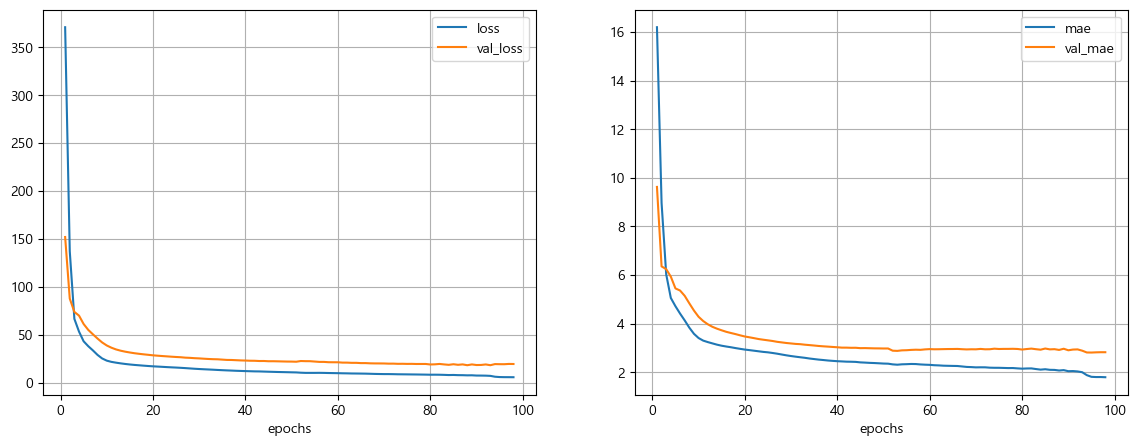

In [12]:
model = tuner.hypermodel.build(best_hps[0])
result = tf_train(model, x_train, y_train, x_test, y_test)
tf_result(result)